In [58]:
import pandas as pd
dfs = []
for f in ["juyo-%s.txt"%_ for _ in range(2016,2020)]:
    df = pd.read_csv(f,skiprows=2,encoding="cp932")
    df.columns = ["date","time","demand"]
    df["datetime"] = df[["date","time"]].apply(lambda dt: "%s %s"%(dt[0],dt[1]),axis=1)
    df = df[["datetime","demand"]]
    df["datetime"] = df["datetime"].astype("datetime64")
    dfs.append(df)
dfs = pd.concat(dfs,axis=0)

# from hourly to daily
dfs["date"] = dfs["datetime"].dt.date
dfs_date = dfs[["date","demand"]].groupby("date").sum().to_dict()["demand"]
dfs_date = pd.DataFrame({"date":list(dfs_date.keys()), "demand":list(dfs_date.values())})
dfs_date.to_csv("juyo-2016_2019.csv",index=False)

In [59]:
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import matplotlib as mpl
mpl.rcParams['font.family'] = ['serif']

url = "juyo-2016_2019.csv"

dataNormal = pd.read_csv(url)
print(dataNormal.shape)
dataNormal.head()

(1370, 2)


,date,demand
0,2016-04-01,71626
1,2016-04-02,69778
2,2016-04-03,63798
3,2016-04-04,70949
4,2016-04-05,76572


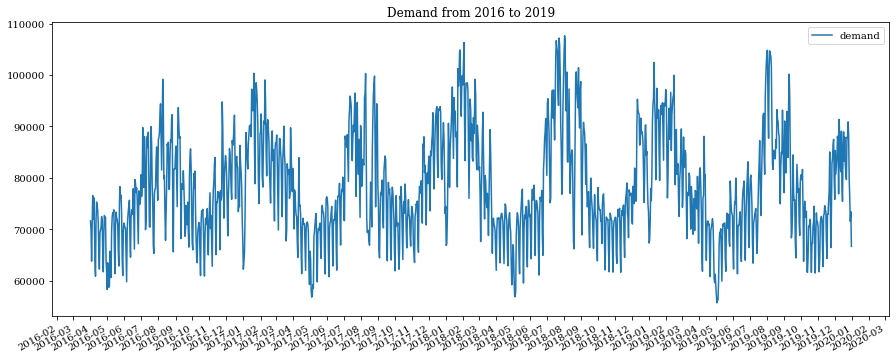

In [70]:
import matplotlib.dates as mdate

plt.plot(dataNormal["date"],dataNormal["demand"], label='demand')
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.title("Demand from 2016 to 2019")
plt.legend(loc="best")
plt.show()

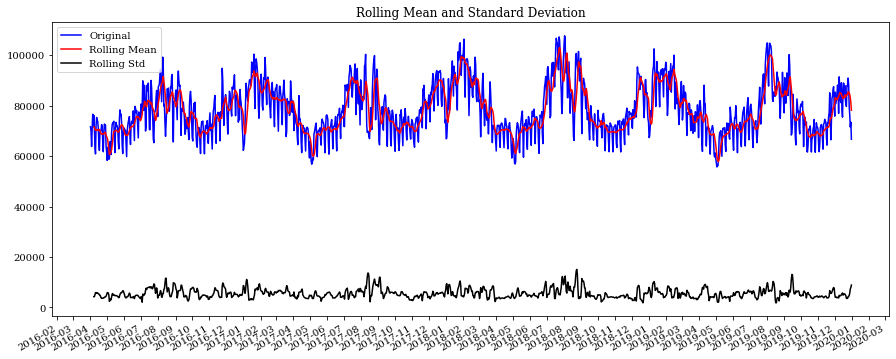

Results of Dickey-Fuller Test:
Test Statistic                   -4.467454
p-value                           0.000225
#Lags Used                       21.000000
Number of Observations Used    1348.000000
Critical Value (1%)              -3.435210
Critical Value (5%)              -2.863686
Critical Value (10%)             -2.567913
dtype: float64


In [69]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window_size=12):
    rolmean = timeseries["demand"].rolling(window=window_size, center=False).mean()
    rolstd = timeseries["demand"].rolling(window=window_size, center=False).std()
    
    orig = plt.plot(timeseries["date"],timeseries["demand"], color='blue', label='Original')
    mean = plt.plot(timeseries["date"],rolmean, color='red', label='Rolling Mean')
    std = plt.plot(timeseries["date"],rolstd, color='black', label='Rolling Std')
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries["demand"], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
dataNormal["date"] = dataNormal["date"].astype("datetime64")
test_stationarity(dataNormal, window_size=7)

Index(['date', 'demand', 'demand_log'], dtype='object')


Text(0.5, 1.0, 'demand(log) from 2016 to 2019')

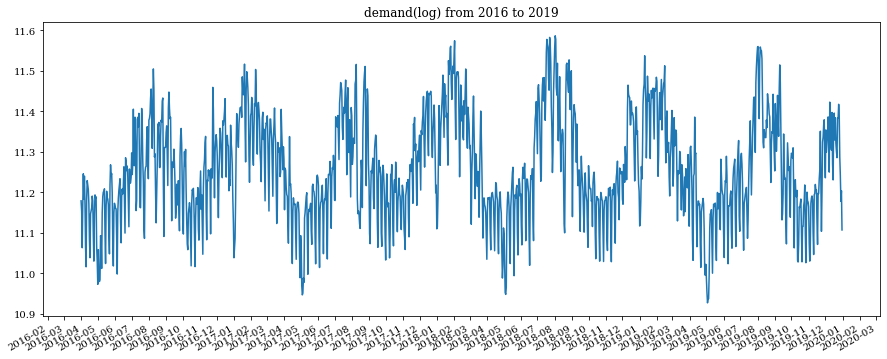

In [75]:
dataNormal_log = dataNormal.copy()
dataNormal_log["demand_log"] = np.log(dataNormal_log["demand"])
print(dataNormal_log.columns)
plt.plot(dataNormal_log["date"], dataNormal_log["demand_log"], label='demand(log)')
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.title('demand(log) from 2016 to 2019')

2016-04-01    71626
2016-04-02    69778
2016-04-03    63798
2016-04-04    70949
2016-04-05    76572
              ...  
2019-12-27    79824
2019-12-28    76246
2019-12-29    71523
2019-12-30    73433
2019-12-31    66657
Freq: D, Name: demand, Length: 1370, dtype: int64


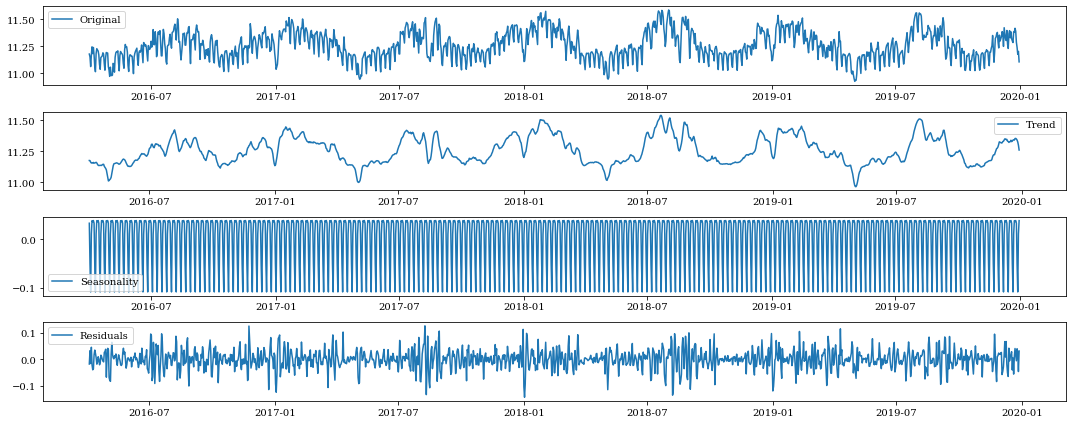

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose
#dataNormal_log.index = dataNormal_log["date"]
dataNormal_log.index = pd.DatetimeIndex(dataNormal_log.index.values,
                                        freq=dataNormal_log.index.inferred_freq)
decomposition = seasonal_decompose(dataNormal_log["demand_log"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dataNormal_log["demand_log"], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [129]:
import statsmodels.api as sm

num = 0

max_p, max_d, max_q = 3, 1, 3
max_sp, max_sd, max_sq = 1, 1, 1
rows = max_p*(max_d+1)*(max_q+1)*(max_sp+1)*(max_sd+1)*(max_sq+1)
modelSelection = pd.DataFrame([[None,None] for _ in range(rows)],columns=["model","aic"])

for p in range(1, max_p+1):
    for d in range(0, max_d+1):
        for q in range(0, max_q+1):
            for sp in range(0, max_sp+1):
                for sd in range(0, max_sd+1):
                    for sq in range(0, max_sq+1):
                        sarima = sm.tsa.SARIMAX(
                            dataNormal_log["demand"], order=(p,d,q),
                            seasonal_order = (sp,sd,sq,4),
                            enforce_stationarity = False,
                            enforce_invertibility = False
                        ).fit()
                        modelSelection.iloc[num]["model"] = "order=(" + str(p) + "," + str(d) + "," + str(q) + \
                                                            "), season=(" + str(sp) + "," + str(sd) + "," + str(sq) + ")"
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1
                        
print(modelSelection)

print(modelSelection[modelSelection.aic == min(modelSelection.aic)])

C:\Users\jpbs\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jpbs\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jpbs\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jpbs\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jpbs\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Lik

                             model      aic
0    order=(1,0,0), season=(0,0,0)  27629.5
1    order=(1,0,0), season=(0,0,1)  27546.8
2    order=(1,0,0), season=(0,1,0)  28279.3
3    order=(1,0,0), season=(0,1,1)  27714.1
4    order=(1,0,0), season=(1,0,0)  27546.6
..                             ...      ...
187  order=(3,1,3), season=(0,1,1)  27317.1
188  order=(3,1,3), season=(1,0,0)  26989.4
189  order=(3,1,3), season=(1,0,1)  26898.5
190  order=(3,1,3), season=(1,1,0)  27508.8
191  order=(3,1,3), season=(1,1,1)  27268.7

[192 rows x 2 columns]
                             model      aic
189  order=(3,1,3), season=(1,0,1)  26898.5


In [130]:
p, d, q = 3, 1, 3
sp, sd, sq = 1, 0, 1

sarima = sm.tsa.SARIMAX(
    dataNormal_log["demand"], order=(p,d,q),
    seasonal_order = (sp,sd,sq,4),
    enforce_stationarity = False,
    enforce_invertibility = False
).fit()

print(sarima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                 1370
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 4)   Log Likelihood              -13440.272
Date:                             Wed, 01 Sep 2021   AIC                          26898.544
Time:                                     19:11:45   BIC                          26945.488
Sample:                                 04-01-2016   HQIC                         26916.118
                                      - 12-31-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2408      0.061      3.957      0.000       0.122       0.360
ar.L2         -0.6567      

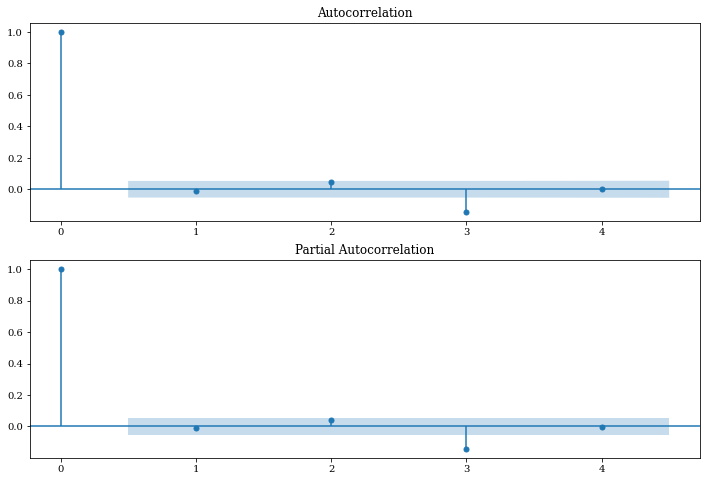

In [131]:
residSARIMA = sarima.resid
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=4, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=4, ax=ax2)

2019-10-01    81836.150289
2019-10-02    76555.419693
2019-10-03    80137.575252
2019-10-04    80952.190707
2019-10-05    78997.879404
                  ...     
2020-01-03    76828.720873
2020-01-04    75432.909207
2020-01-05    77054.679324
2020-01-06    79064.556927
2020-01-07    75645.894067
Freq: D, Name: predicted_mean, Length: 99, dtype: float64


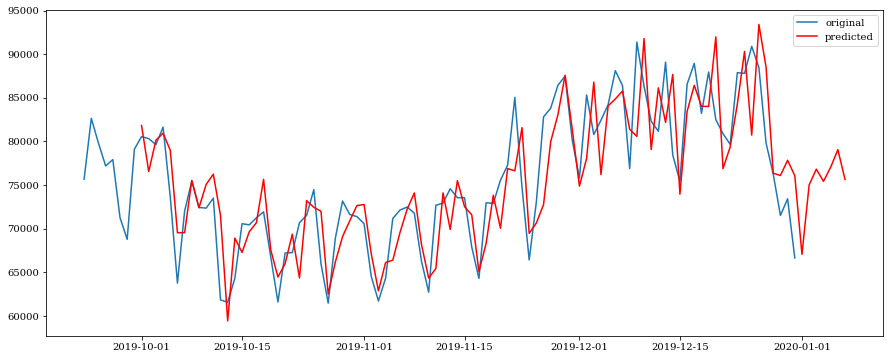

In [141]:
dataNormal_pred = sarima.predict('2019-10-01', '2020-1-7')

plt.plot(dataNormal_log.iloc[-100:]["demand"], label="original")
plt.plot(dataNormal_pred, label="predicted",color="red")
plt.legend(loc="best")

print(dataNormal_pred)